In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions

from linux_qm.src.render import draw_reacting_mapnums

In [2]:
df = pd.read_csv('../data/slv_amides/amide_mapped_training_set.csv')
df.sample(5)

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi
3114,11749418,OC(=O)c1cc(C(C)Nc2cc(F)cc(F)c2)c2oc(N3CCOCC3)c...,COC1CCNCC1,[CH3:1][O:2][CH:3]1[CH2:38][CH2:37][N:6]([C:7]...,N-Hydroxysuccinimide,65.0,[CH3:1][O:2][CH:3]1[CH2:8][CH2:7][NH:6][CH2:5]...
3879,14183466,OC(c1c[n]c(N2CCN(C3CCN(C(OC(C)(C)C)=O)CC3)[C@H...,NC1CC1,[CH3:1][C:2]([O:5][C:6]([N:8]1[CH2:36][CH2:35]...,NaN,65.0,[NH2:1][CH:2]1[CH2:4][CH2:3]1.O[C:6](=[O:37])[...
961,6358815,OC(CC(OC(C)C)=O)=O,Nc1cccc(Cl)c1Cl,[CH3:1][CH:2]([O:4][C:5]([CH2:7][C:8]([NH:10][...,NaN,59.0,[NH2:1][c:2]1[c:8]([Cl:9])[c:6]([Cl:7])[cH:5][...
9093,32416345,OC(C1C(C(OCC)=O)=C(C)NC(C)=C1C(=O)OCC)=O,NCc1ccccc1,[CH3:1][CH2:2][O:3][C:4]([C:6]1[CH:18]([C:19](...,Other,67.0,[NH2:1][CH2:2][c:3]1[cH:8][cH:7][cH:6][cH:5][c...
1678,8383821,OC(CNC(OC(C)(C)C)=O)=O,N[C@@H](Cc1ccc(O)c([N+](=O)[O-])c1)C(=O)O,[CH3:1][C:2]([O:5][C:6]([NH:8][CH2:9][C:10]([N...,N-Hydroxysuccinimide,94.0,[NH2:1][C@H:2]([C:14]([OH:16])=[O:15])[CH2:3][...


[NH2:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1.O[C:11](=[O:15])[CH2:12][C:13]#[N:14]>>[N:14]#[C:13][CH2:12][C:11](=[O:15])[NH:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 11


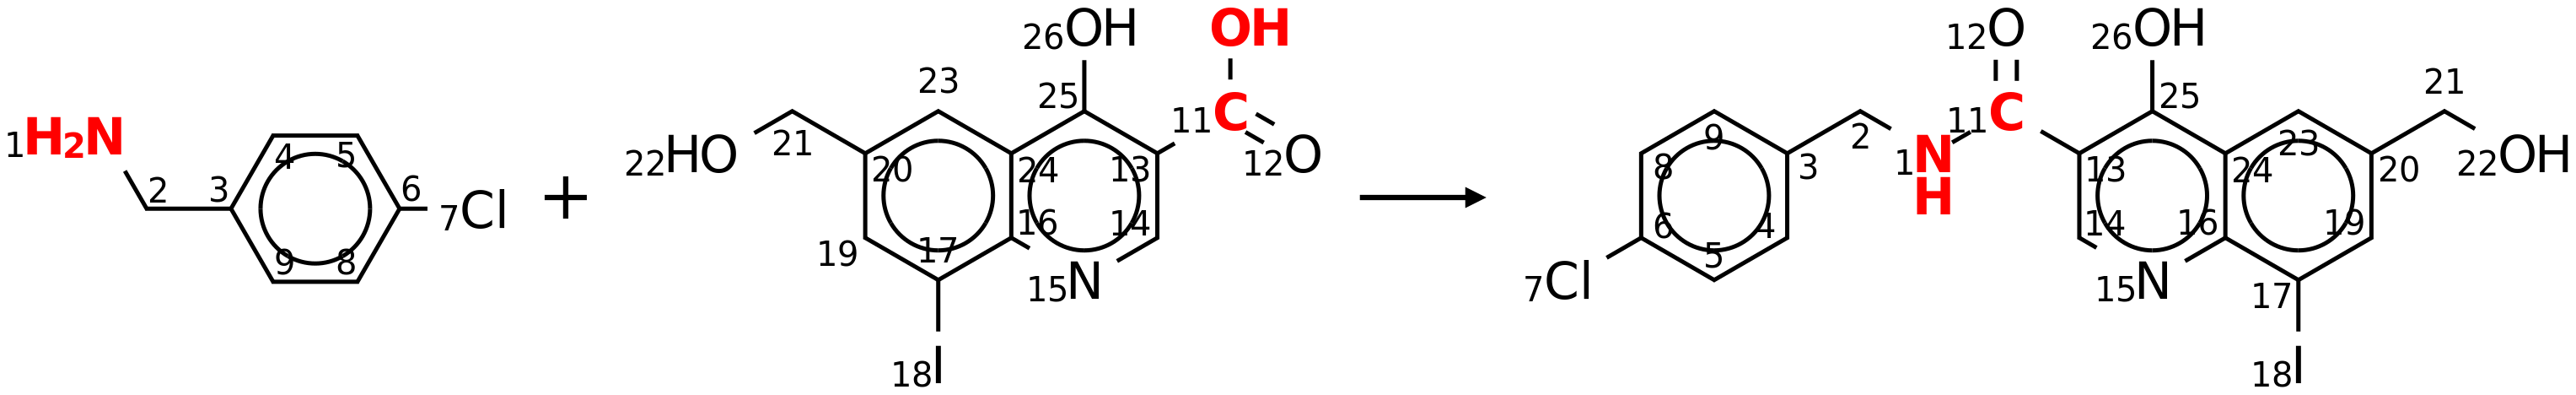

[1, 0, 11]

In [11]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)
draw_reacting_mapnums(df.rxn_smi.sample(1).iat[0])

# SMARTS Amine Descriptor

In [122]:
amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
amine_smarts_df

,SMARTS,Description
0,[NH2;!$(NC=O)],primary amine
1,[NH1;!$(NC=O)],secondary amine
2,[NH1;r3;!$(NC=O)],amine in a 3-membered ring
3,[NH1;r4;!$(NC=O)],amine in a 4-membered ring
4,[NH1;r5;!$(NC=O)],amine in a 5-membered ring
...,...,...
124,"[NX3;H2,H1;!$(NC=O)]-a1saaa1",N - alpha aromatic S in aromatic 5-membered ar...
125,"[NX3;H2,H1;!$(NC=O)]-a1asaa1",N - beta aromatic S in aromatic 5-membered aro...
126,"[NX3;H2,H1;!$(NC=O)]-a1naaaa1",N - ortho aromatic N in aromatic 6-membered ar...
127,"[NX3;H2,H1;!$(NC=O)]-a1anaaa1",N - meta aromatic N in aromatic 6-membered aro...


In [123]:
smarts = amine_smarts_df.SMARTS.iat[8]
query = Chem.MolFromSmarts(smarts)
query

def check_query(smarts):
    try:
        Chem.MolFromSmarts(smarts)
        return True
    except:
        return False

amine_smarts_df.SMARTS.apply(check_query).sum() == len(amine_smarts_df)

True

In [124]:
def has_match(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.HasSubstructMatch(query)

def match_atoms(smi: str, query):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetSubstructMatch(query)

mol = Chem.MolFromSmiles('Nc1ccccc1')
queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
for query in queries:
    mol.GetSubstructMatch(query)

In [125]:
mask = df.amine_smi.apply(has_match, args=(query,))

(0, 1, 2, 4, 5, 6, 8)
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 11


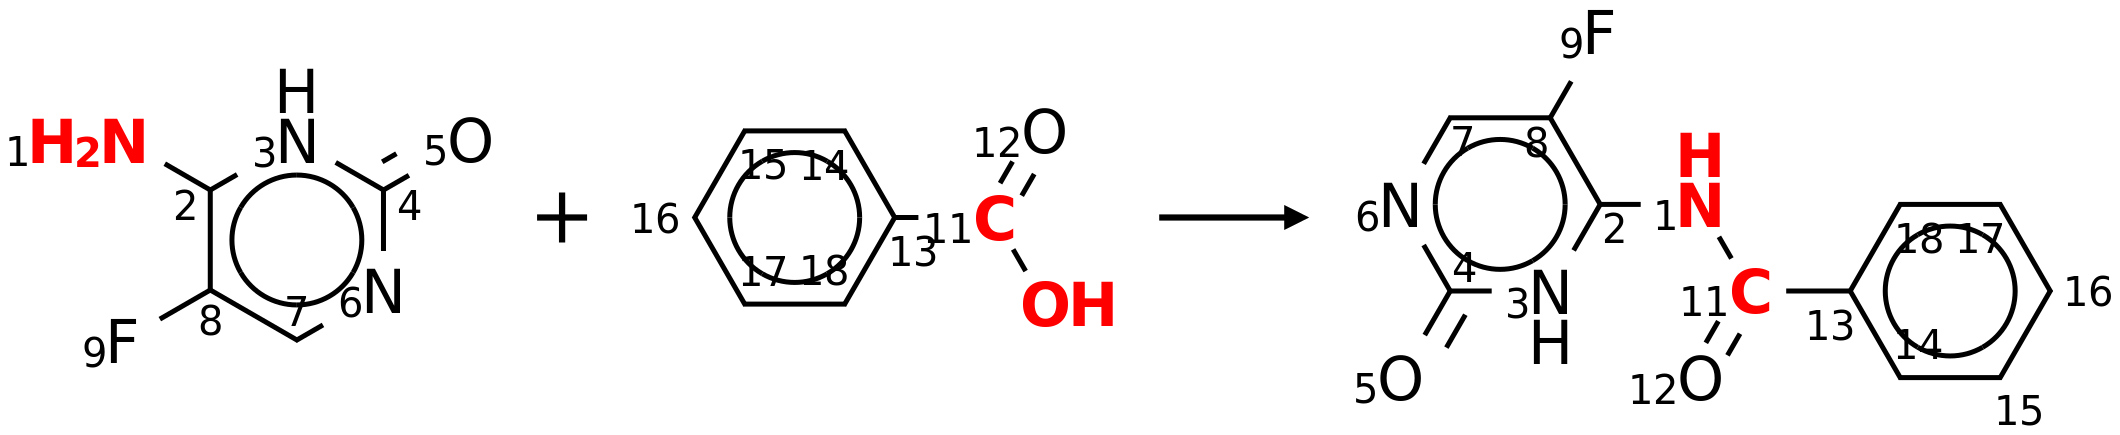

[1, 0, 11]

In [126]:
rxn_smi = df.loc[mask, 'rxn_smi'].sample(1).iat[0]
print(match_atoms(rxn_smi.split('.')[0], query))
draw_reacting_mapnums(rxn_smi)

In [127]:
def match_queries(mol, queries: list, react_atom_id: int):
    size = len(queries)
    result = np.zeros(size, dtype=int)
    for i, query in enumerate(queries):
        result[i] = match_reacting_atom(mol, query, react_atom_id)
    return result

def match_reacting_atom(mol, query, react_atom_id: int):
    try:
        for match_atoms in mol.GetSubstructMatches(query):
            # print('match_atoms:', match_atoms)
            if react_atom_id == match_atoms[0]:
                return True
        return False
    except Exception as e:
        print(f"{type(e).__name__}: {e} \n for query: {Chem.MolToSmarts(query)}\n for smiles: {Chem.MolToSmiles(mol)}")


In [138]:
def load_query(smarts: str):
    query = Chem.MolFromSmarts(smarts)
    query.UpdatePropertyCache()
    Chem.GetSymmSSSR(query)
    return query

queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
# queries = amine_smarts_df.SMARTS.apply(load_query)

def update_props(mol):
    mol.UpdatePropertyCache()
    Chem.GetSymmSSSR(mol)

def smarts_descriptor(rxn_smi, queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    return match_queries(amine, queries, react_nitrogen)

smarts_descriptor(rxn_smi, queries)

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [129]:
from linux_qm.desc.smarts import smarts_descriptor

smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
queries = smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_descriptor(rxn_smi, queries)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

# SMARTS Acid descriptor

In [179]:
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
acid_smarts_df

,SMARTS,Description
0,[C](=[O])(-[OH])-[*]~[*+],CA - * - positive charge
1,[C](=[O])(-[OH])-[*]~[*]~[*+],CA - * - * - positive charge
2,[C](=[O])(-[OH])-[*]~[*-],CA - * - negative charge
3,[C](=[O])(-[OH])-[*]~[*]~[*-],CA - * - * - negative charge
4,[C](=[O])(-[OH])-[R]1~[R]~[R]1,CA - ring of size 3
...,...,...
118,[OH]-[C](=[O])-a1aanaa1,N - para aromatic N in aromatic 6-membered aro...
119,[OH]-[C](=[O])-a1a(-[CH3])aaaa1,CH3 in -orto position across 6-membered aromat...
120,[OH]-[C](=[O])-a1a(-[CH2][CH2])aaaa1,CH2-CH2 in -orto position across 6-membered ar...
121,[OH]-[C](=[O])-a1a(-[CH]([C])[C])aaaa1,iPr-scaffold in -orto position across 6-member...


In [180]:
queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

51


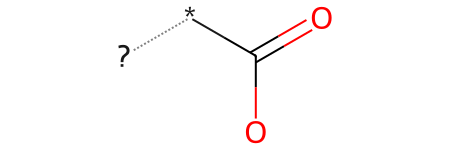

In [218]:
query = queries[0]

mask = df.acid_smi.apply(has_match, args=(query,))
print(mask.sum())

query

In [231]:
count = {}

for query in tqdm(queries):
    mask = df.acid_smi.apply(has_match, args=(query,))
    count[Chem.MolToSmarts(query)] = mask.sum()

count

100%|██████████| 123/123 [01:16<00:00,  1.60it/s]


{'C(=O)(-[O&H1])-*~[+]': 51,
 'C(=O)(-[O&H1])-*~*~[+]': 45,
 'C(=O)(-[O&H1])-*~[-]': 0,
 'C(=O)(-[O&H1])-*~*~[-]': 51,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]1': 107,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]1': 30,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]~[R]1': 1640,
 'C(=O)(-[O&H1])-[R]1~[R]~[R]~[R]~[R]~[R]1': 3385,
 '[O&H1]-C(=O)-[R]1~[R]~[R]~[R]~[R]~[R]~[R]1': 36,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]1': 5,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]1': 15,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]1': 318,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]~[R]1': 573,
 '[O&H1]-C(=O)-*-[R]1~[R]~[R]~[R]~[R]~[R]~[R]1': 13,
 '[O&H1]-C(=O)-[a&R]': 3968,
 '[O&H1]-C(=O)-[!R]~[a&R]': 516,
 '[O&H1]-C(=O)-[!R]~[!R]~[a&R]': 782,
 '[O&H1]-C(=O)-[A&R]': 1147,
 '[O&H1]-C(=O)-[!R]~[A&R]': 268,
 '[O&H1]-C(=O)-[!R]~[!R]~[A&R]': 105,
 '[O&H1]-C(=O)~[#7,#8,#15,#16]': 0,
 '[O&H1]-C(=O)~*~[#7,#8,#15,#16]': 3685,
 '[O&H1]-C(=O)~*~*~[#7,#8,#15,#16]': 4306,
 '[O&H1]-C(=O)-[C&H3]': 0,
 '[O&H1]-C(=O)-[C&H2]-[C&H3]': 180,
 '[O&H1]-C(=O)-[C&H2]': 3134,
 '[O&H1]-C(=O)

Reacting Atom Idx: ((23,), (0, 1))
Mapped reacting atom: N 10
Mapped reacting atom: O 0
Mapped reacting atom: C 30


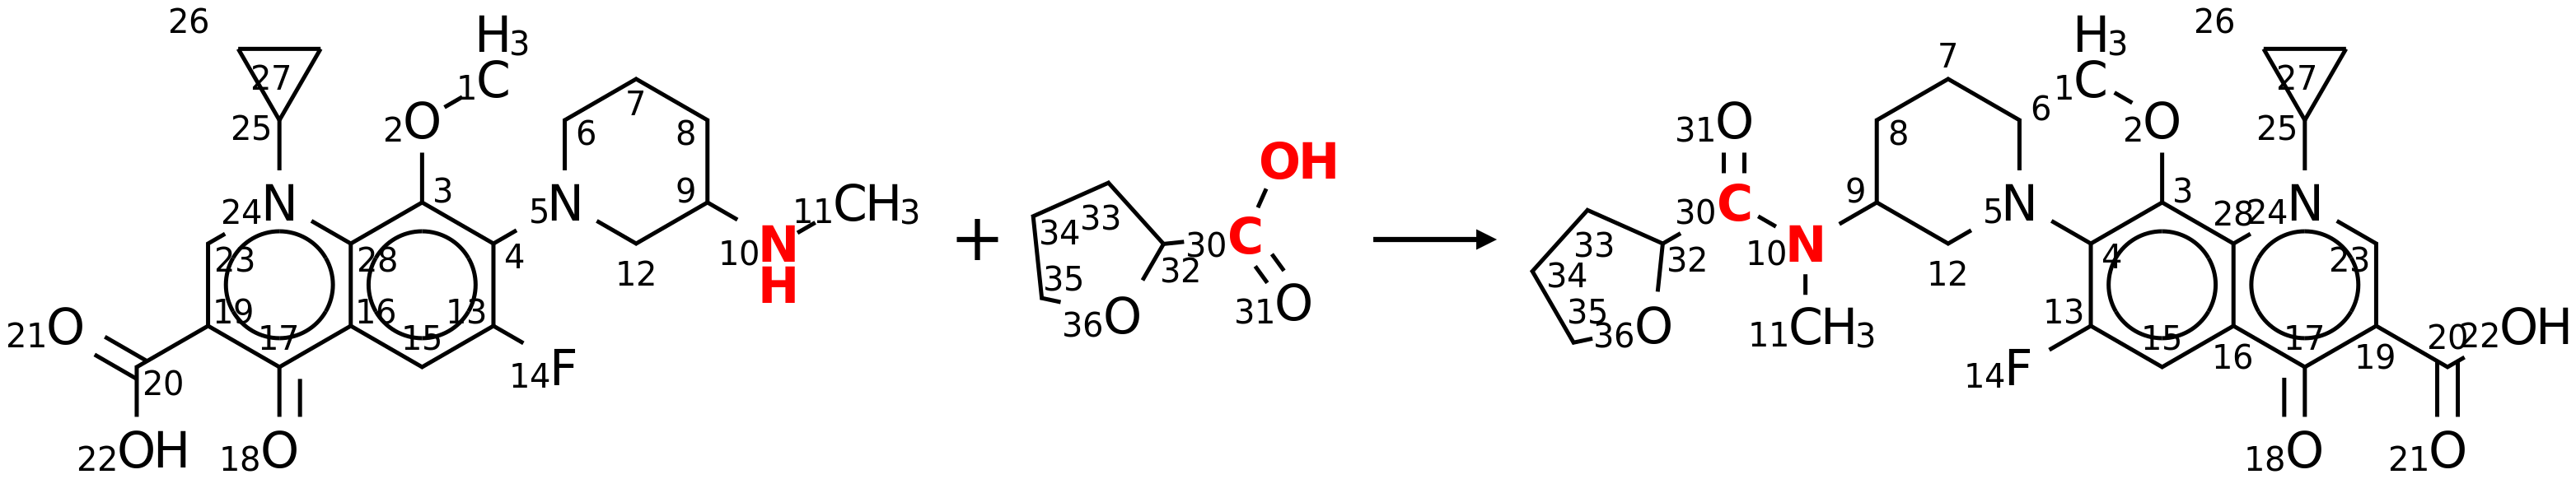

[10, 0, 30]

In [164]:
rxn_smi = df.rxn_smi[mask].sample(1).iat[0]
draw_reacting_mapnums(rxn_smi)

In [151]:
def get_first_ratom_acid(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    react_atoms_ids = rxn.GetReactingAtoms()
    react_carbon = react_atoms_ids[1][1]
    return acid.GetAtomWithIdx(react_carbon).GetSymbol()

o_mask = df.rxn_smi.apply(get_first_ratom_acid) == 'O'

Reacting Atom Idx: ((0,), (23, 25))
Mapped reacting atom: N 1
Mapped reacting atom: C 9
Mapped reacting atom: O 0


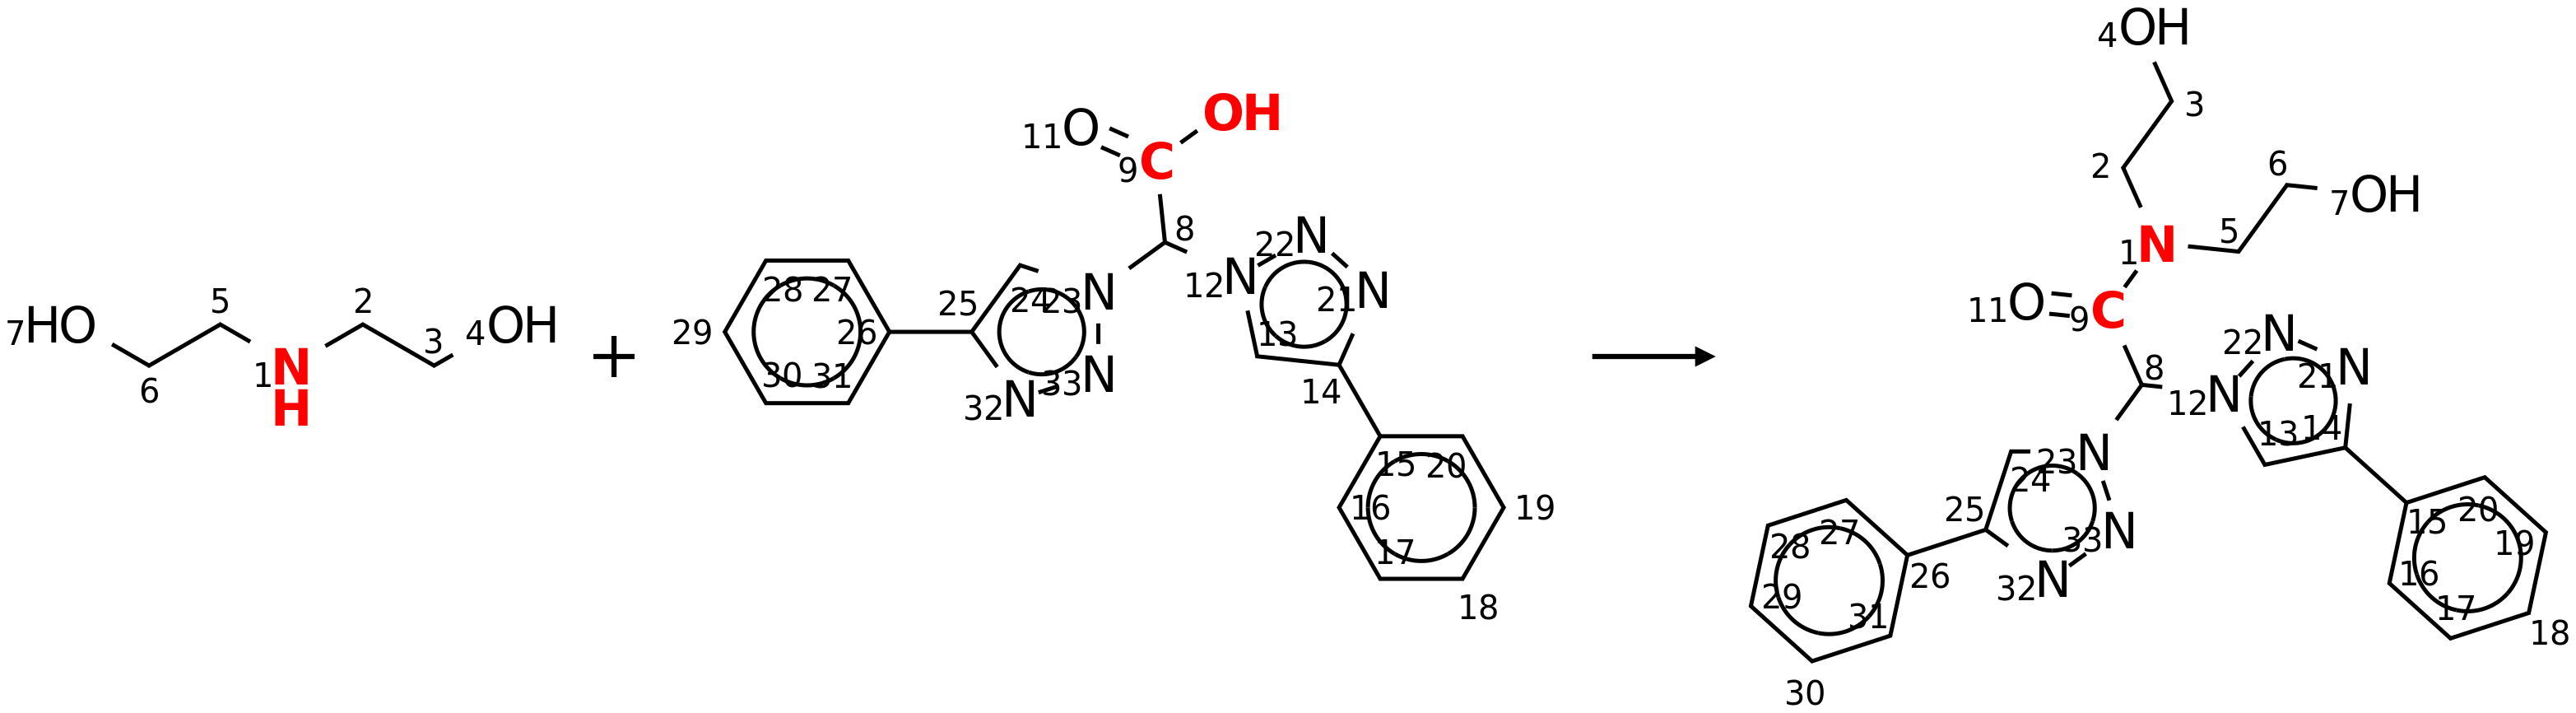

[1, 9, 0]

In [160]:
draw_reacting_mapnums(df[o_mask].sample(1).rxn_smi.iat[0])

In [161]:
def find_acid_carbon(acid, react_atoms: list):
    for i in react_atoms:
        if acid.GetAtomWithIdx(i).GetSymbol() == 'C':
            return i

In [163]:
def smarts_descriptor(rxn_smi, amine_queries: list, acid_queries: list):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()
    amine, acid = rxn.GetReactants()
    update_props(amine)
    update_props(acid)
    react_atoms_ids = rxn.GetReactingAtoms()

    react_nitrogen = react_atoms_ids[0][0]
    react_carbon = find_acid_carbon(acid, react_atoms_ids[1])
    amine_descr = match_queries(amine, amine_queries, react_nitrogen)
    acid_descr = match_queries(acid, acid_queries, react_carbon)
    return np.hstack([amine_descr, acid_descr])

amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [3]:
from rdkit import Chem
import pandas as pd

from linux_qm.desc.smarts import smarts_descriptor

rxn_smi = "[NH2:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1.O[C:11](=[O:15])[CH2:12][C:13]#[N:14]>>[N:14]#[C:13][CH2:12][C:11](=[O:15])[NH:1][CH2:2][CH2:3][c:4]1[cH:9][cH:8][cH:7][cH:6][cH:5]1"

amine_smarts_df = pd.read_csv('../data/smarts/Amine_SMARTS.csv')
acid_smarts_df = pd.read_csv('../data/smarts/Acid_SMARTS.csv')
amine_queries = amine_smarts_df.SMARTS.apply(Chem.MolFromSmarts)
acid_queries = acid_smarts_df.SMARTS.apply(Chem.MolFromSmarts)

smarts_descriptor(rxn_smi, amine_queries ,acid_queries)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])